In [1]:
import re
import graphviz
from IPython import display
import lxml.etree
import more_itertools
import pandas
import itertools
import networkx

In [2]:
def matrix_entries(scene_div):
    index = []
    x = scene_div
    while x != None:
        if len(x.xpath('preceding-sibling::div')) == 0 and len(x.xpath('following-sibling::div')) == 0:
            x = x.getparent()
        else:
            index = [x.getparent().xpath('./div').index(x)] + index
            x = x.getparent()

    label = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VII', 'VIII', 'IX', 'X'][index[0]] + '.' + '.'.join(map(lambda x: str(x+1), index[1:]))


    for sp in scene_div.xpath('./sp'):
        for speaker in [ s[1:] for s in sp.get('who').split(' ') ]:
            word_count = 0
            for x in sp.xpath('.//text()[not(ancestor::stage or ancestor::speaker)]'):
                word_count += len(re.findall(r'\b\w+\b', x))
            yield (label, speaker, word_count)
            
def get_drama_matrix(etree):
    for elem in tree.getiterator():
        elem.tag = lxml.etree.QName(elem).localname
    # Remove unused namespace declarations
    lxml.etree.cleanup_namespaces(tree)

    entries = [e for div in tree.xpath('//body//div[./sp and not(./div)]') for e in matrix_entries(div)]
    y = pandas.DataFrame(entries, columns=['scene', 'speaker', 'n'])
    nodup = y[['scene', 'speaker']].drop_duplicates()

    matrix = pandas.DataFrame(entries, columns=['scene', 'speaker', 'n'])\
        .groupby(by=['scene', 'speaker']).sum()\
        .reset_index()\
        .pivot(index='speaker', columns='scene', values='n')\
        [[ y[0] for y in itertools.groupby([ x[0] for x in entries ]) ]]

    return matrix
            
def path_cover(simple_graph):
    bipG = networkx.Graph()
    bipG.add_weighted_edges_from([ (('l', u), ('r', v), w) for u,v,w in simple_graph.edges(data='weight') ])
    edges = []
    for x,y in networkx.algorithms.matching.max_weight_matching(bipG):
        if x[0] == 'l': edges.append((x[1], y[1]))
        else: edges.append((y[1], x[1]))
        
    subgraph = simple_graph.copy()
    subgraph.clear_edges()
    subgraph.add_edges_from(edges)
    
    paths = []
    for c in networkx.algorithms.weakly_connected_components(subgraph):
        paths.append(list(networkx.algorithms.topological_sort(subgraph.subgraph(c))))
    return paths
            
def plot_graph(G):
    G = G.copy()
    G.graph['graph'] = {'rankdir': 'LR'}
    G.graph['node'] = {'shape': 'circle', 'style': 'filled', 'fixedsize': True, 'width': 0.1, 'fontsize': 14, 'margin': 1}

    A=networkx.nx_agraph.to_agraph(G)
    for n in A.nodes():
        A.get_node(n).attr['label'] = ''
        A.get_node(n).attr['xlabel'] = str(n)
    A.layout('dot')
    return graphviz.Source(A.to_string())

## Visualisierung der Konfigurationsmatrix (Galotti)

In [3]:
tree = lxml.etree.parse('lessing-emilia-galotti.xml')
matrix = get_drama_matrix(tree)
matrix

scene,I.1,I.2,I.3,I.4,I.5,I.6,I.7,I.8,II.1,II.2,...,IV.7,IV.8,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8
speaker,,,,,,,,,,,,,,,,,,,,,
angelo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appiani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
battista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
camillo_rota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claudia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,82.0,...,NaN,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conti,NaN,81.0,NaN,523.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_kammerdiener,31.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_prinz,205.0,70.0,106.0,582.0,105.0,692.0,186.0,102.0,NaN,NaN,...,NaN,NaN,78.0,NaN,NaN,NaN,466.0,NaN,NaN,68.0
emilia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,508.0,11.0


In [4]:
colors = pandas.DataFrame(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#17becf'], columns=['color'])
figure_colors = (~matrix.isna()).sum(axis=1).sort_values(ascending=False).reset_index()\
    .merge(colors, left_index=True, right_index=True, how='outer')\
    .set_index('speaker')['color'].fillna('#444444')
#figure_colors.to_csv('legend.csv', header=False)
pandas.DataFrame(figure_colors).style.applymap(lambda x: f'background-color: {x}')

,color
speaker,
marinelli,#1f77b4
der_prinz,#ff7f0e
claudia,#2ca02c
odoardo,#d62728
emilia,#9467bd
orsina,#8c564b
appiani,#e377c2
battista,#bcbd22
pirro,#17becf


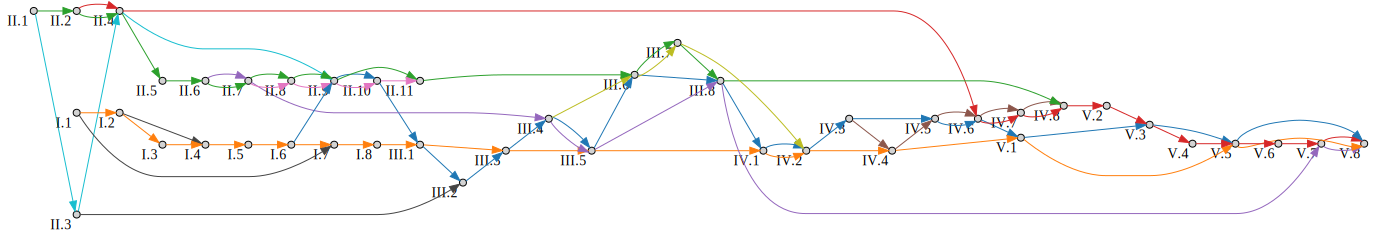

In [5]:
G = networkx.MultiDiGraph()
for p in matrix.index:
    for x, y in more_itertools.windowed(matrix.loc[p,:].dropna().items(), 2):
        if y is None:
            G.add_node(x[0])
            continue
        u = x[0]
        v = y[0]
        weight = min(x[1], y[1])

        
        G.add_edge(u, v, figure=p, weight=weight, color=figure_colors[p])

networkx.write_graphml(G, 'galotti.graphml', named_key_ids=True)
plot_graph(G)

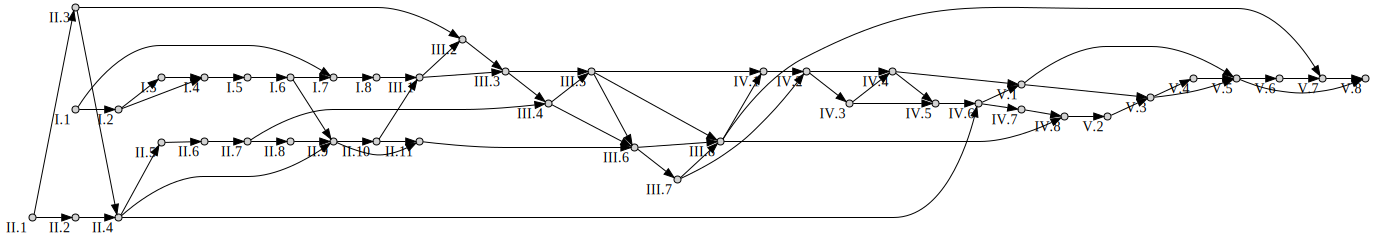

In [6]:
Gsim = networkx.DiGraph()

for u,v, keys, weight in G.edges(data='weight', keys=True):
    if Gsim.has_edge(u, v):
        Gsim.get_edge_data(u,v)['weight'] += weight
    else:
        Gsim.add_edge(u,v, weight=weight)
        
plot_graph(Gsim)

## Berechnung gewichtsmaximaler Wegüberdeckung (Götz)

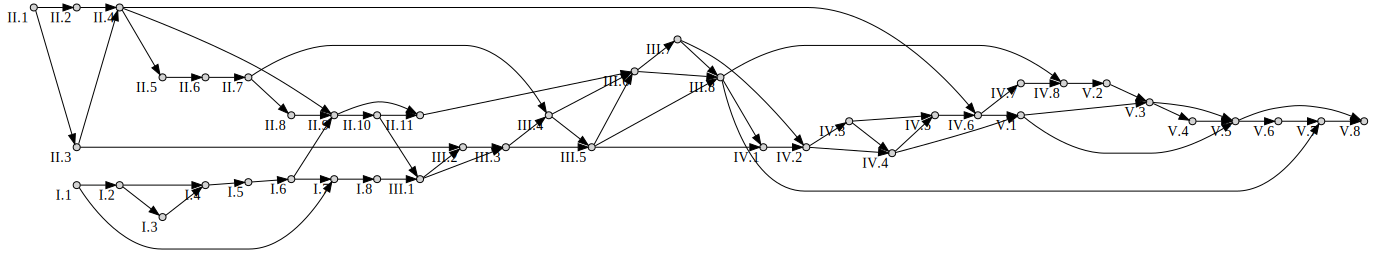

In [7]:
matrix = get_drama_matrix(lxml.etree.parse('goethe-götz-von-berlichingen.xml'))
Gsim = networkx.DiGraph()

for p in matrix.index:
    for x, y in more_itertools.windowed(matrix.loc[p,:].dropna().items(), 2):
        if y is None:
            G.add_node(x[0])
            continue
        u = x[0]
        v = y[0]
        weight = min(x[1], y[1])

        if Gsim.has_edge(u, v):
            Gsim.get_edge_data(u,v)['weight'] += weight
        else:
            Gsim.add_edge(u,v, weight=weight)
            
plot_graph(Gsim)

Path #1:  ['II.3', 'III.2']
Path #2:  ['II.1', 'II.2', 'II.4', 'II.5', 'II.6', 'II.7', 'II.8', 'II.9', 'II.10', 'III.1', 'III.3', 'III.4', 'III.5', 'IV.1', 'IV.2', 'IV.3', 'IV.5', 'IV.6', 'IV.7', 'IV.8', 'V.2']
Path #3:  ['II.11', 'III.6', 'III.8']
Path #4:  ['III.7']
Path #5:  ['I.1', 'I.2', 'I.3', 'I.4', 'I.5', 'I.6', 'I.7', 'I.8']
Path #6:  ['IV.4', 'V.1', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8']


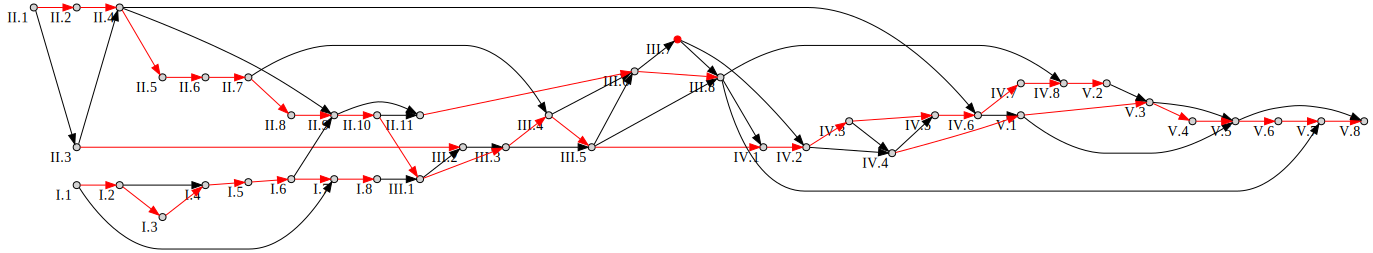

In [8]:
for i, path in enumerate(path_cover(Gsim)):
    print(f'Path #{i+1}: ', path)
    if len(path) == 1:
        Gsim.nodes[path[0]]['color'] = 'red'
    else:
        for u,v in networkx.utils.pairwise(path): 
            if not Gsim.has_edge(u,v):
                tmp = u
                u = v
                v = tmp
            Gsim.get_edge_data(u,v)['color'] = 'red'
    
networkx.write_graphml(Gsim, 'götz.graphml', named_key_ids=True)
plot_graph(Gsim)